Мы познакомимся с генерацией нормального белого шума и посмотрим на практике, как влияет на качество OLS оценок гетероскедастичность

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

Создадим нормальный белый шум размера N с нулевым средним и единичной дисперсией. Его график совершенно хаотичен

In [29]:
N = 40

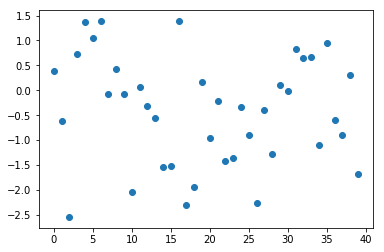

In [30]:
mu = 0
sigma = 1 

eps = np.random.normal(mu, sigma, size=N)

plt.scatter(np.arange(N),eps)

Соединим соседние точки линиями. Это полезно, когда в качестве счетчика выступает время

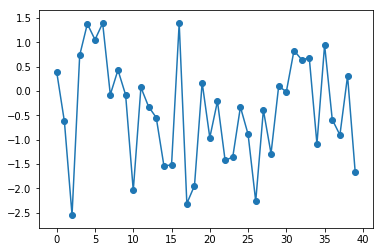

In [31]:
plt.plot(eps)
plt.scatter(np.arange(N),eps)

Сгенерируем данные для регрессии: добавим к линейной функции y=2+x белый шум eps. Диаграмма рассеяния показывает сильный линейный паттерн и в целом ведет себя хорошо

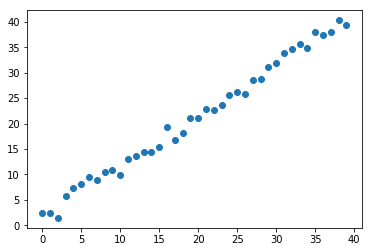

In [32]:
x = np.arange(N)
y = 2 + x + eps
plt.scatter(x,y)

Подготовим данные для обучения классической OLS регрессии. Все условия Гаусса-Маркова выполняются: признак детерминированный (числа от 1 до N), модель хорошая, шум белый.
Мы будем пользоваться не lstsq из linalg.numpy, а  конструктором LinearRegression() из библиотеки sklearn.
Как вы помните, lstsq работает на svd разложении и требует предварительной стандартизации данных в случае существенно разных шкал признаков.
LinearRegression() делает стандартизацию сама (впрочем, это можно настроить), однако следует иметь в виду, что алгоритм внутри нее зашит другой, тоже устойчивый к "плохим" данным. Как правило, реализации алгоритмов в sklearn направлены на то, чтобы функция работала быстро.
Реализация OLS через теоретическую формулу на практике не применяется из-за плохой вычислительной устойчивости.

In [34]:
# сначала переформатируем данные из одномерных массивов в двумерные, тк этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

[1.76569329] [[0.99091622]]


Одной из метрик качества модели является r2_score. Это так называемая доля объяснённой дисперсии. Она показывает, какую часть отклонений целевой переменной объясняет модель. Чем выше, тем лучше.

In [35]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.9912381345225213

Теперь давайте испортим немного модель, добавив гетероскедастичность

In [36]:
# создадим функцию, которая будет портить белый шум, добавляя в него неравные дисперсии.
# Кажое следующее значение шума будет в alpha раз выше предыдущего

def hetero_eps(alpha, eps):
    hetero_eps = np.zeros(len(eps))
    for i in range (0, len(eps)):
        hetero_eps[i] = (alpha**i) * eps[i]
    return hetero_eps

 Возьмем в качестве alpha 1.5, при этом каждое следующее отклонение будет примерно на 5% больше прыдущего
 На графике видно, что шум "расползается". Чем больше измерений мы возьмем, тем сильнее будет расплозаться шум, а с ним и весь тренд.
 В гомоскедастичном случае (для белого шума) чем больше измерений, тем точнее будет настроена регрессия, т.к. никакого расползания там нет

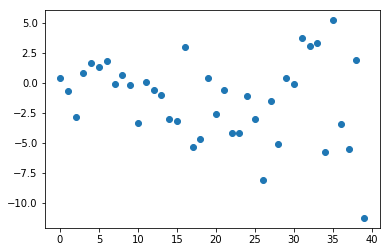

In [37]:
alpha = 1.05
heteps = hetero_eps(alpha,eps) # гетероскедастичный шум
plt.scatter(np.arange(N),heteps)

В модель y = 2 + x добавим гетероскедастичный шум и посмотрим, что будет с регрессией

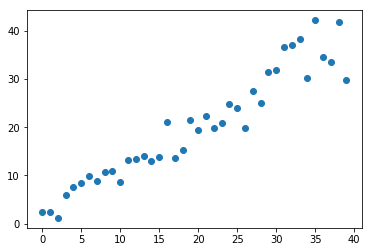

In [38]:
x = np.arange(N)
y = 2 + x + heteps
plt.scatter(x,y) # типичная картинка увеличения дисперсии

In [39]:
# сначала переформатируем данные из одномерных массивов в двумерные, т.к. этого требует синтаксис LinearRegression() 
# при работе с реальными датасетами делать этого не нужно
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

[1.83408428] [[0.94086567]]


Как правило, коэффициенты модели с гетероскедастичностю сильнее отличаются от настоящих значений параметров 2 и 1 по сравнению с гомоскедастичным случаем.  
Пострадает и r2_score - модель с гетероскедатсичным шумом хуже объясняет изменения y. Прогнозы в такой модели тоже будут менее точные

In [40]:
y_pred = linreg.predict(x)
r2_score(y,y_pred)

0.9161787410303956

Пример внизу показывает, что чем больше гетероскедастичность, тем хуже работает модель

In [41]:
x = np.arange(N)

# увеличим амлитуду шума в 4 раза

y = 2 + x + 4*heteps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[1.33633712] [[0.76346267]]
0.31025312089833934


а вот что происходит с увеличением амплитуды шума в гомоскедатсичной модели:

In [42]:
x = np.arange(N)
# увеличим амлитуду шума в 4 раза
y = 2 + x + 4*eps
x=np.reshape(x,(N,1))
y=np.reshape(y,(N,1))
linreg = linear_model.LinearRegression() 

# обучим модель
linreg.fit(x,y)

# выведем коэффициенты
print(linreg.intercept_,linreg.coef_)

# найдем оценки y
y_pred = linreg.predict(x)

# выведем r2_score
print(r2_score(y,y_pred))

[1.06277316] [[0.96366487]]
0.869912399447615


Как видите, intercept модели гуляет, но коэффициент при x оценивается довольно неплохо.
r2_score тоже ожидаемо падает, но не так сильно, как в гетероскедастичном случае.

**ЗАДАНИЕ**

In [15]:
# Загрузите датасет BostonHousing из библиотеки sklearn (с ним мы работали ранее).
data = load_boston()

df = pd.DataFrame(data['data'], columns=data['feature_names'])

# Подготовить данные CRIM и RM
X = df[['CRIM', 'RM']].values
y = data['target']

# Обучите линейную регрессию стоимости дома на параметры CRIM и RM
model = LinearRegression(n_jobs=-1)
model.fit(X, y)

LinearRegression(n_jobs=-1)

In [24]:
# Выведите коэффициенты модели, округлив ответ до сотых:
display(np.round(model.coef_, 2))

# intercept:
display(round(model.intercept_, 2))

array([-0.26,  8.39])

-29.24

**7.3.2**

Найдите долю объясненной дисперсии.

In [27]:
r2_score(y, model.predict(X))

0.5419591738494084

**Задание 7.3.3**

Сгенерируйте вектор белого шума и добавьте к исходным значениям целевой переменой. Обучите модель и найдите $R^2$ (долю объясненной дисперсии).

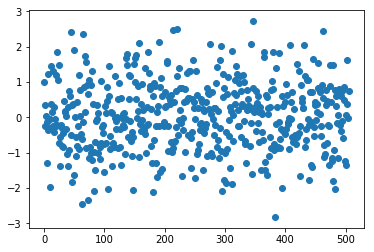

In [45]:
# Сгенерируйте вектор белого шума
N = X.shape[0]
mu = 0
sigma = 1 

eps = np.random.normal(mu, sigma, size=N)

plt.scatter(np.arange(N),eps)

In [46]:
# добавьте к исходным значениям целевой переменой и Обучите модель и найдите R^2
# Подготовить данные CRIM и RM
X = df[['CRIM', 'RM']].values
y = data['target'] + eps

# Обучите линейную регрессию стоимости дома на параметры CRIM и RM
model = LinearRegression(n_jobs=-1)
model.fit(X, y)

LinearRegression(n_jobs=-1)

In [49]:
y_pred = model.predict(X)
r2_score(y,y_pred)

0.5400519638518428

**Задание 7.3.4**

Сгенерируйте вектор гетероскедастичного шума аналогично разобранному примеру с параметром $\alpha = 1.002$ и добавьте к исходным значениям целевой переменной. Обучите модель и найдите $R^2$ (долю объясненной дисперсии).

In [50]:
# создадим функцию, которая будет портить белый шум, добавляя в него неравные дисперсии.
# Кажое следующее значение шума будет в alpha раз выше предыдущего

def hetero_eps(alpha, eps):
    hetero_eps = np.zeros(len(eps))
    for i in range (0, len(eps)):
        hetero_eps[i] = (alpha**i) * eps[i]
    return hetero_eps

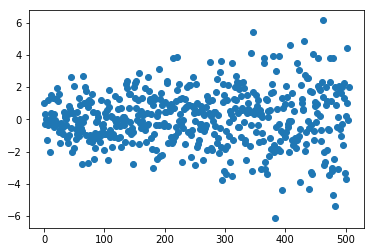

In [51]:
alpha = 1.002
heteps = hetero_eps(alpha,eps) # гетероскедастичный шум
plt.scatter(np.arange(N),heteps)

In [52]:
# добавьте к исходным значениям целевой переменой и Обучите модель и найдите R^2
# Подготовить данные CRIM и RM
X = df[['CRIM', 'RM']].values
y = data['target'] + heteps

# Обучите линейную регрессию стоимости дома на параметры CRIM и RM
model = LinearRegression(n_jobs=-1)
model.fit(X, y)

LinearRegression(n_jobs=-1)

In [53]:
y_pred = model.predict(X)
r2_score(y,y_pred)

0.5348118036191449

**Задание 7.3.6**

Сгенерируйте вектор гетероскедастичного шума аналогично разобранному примеру с параметром $\alpha = 0.998$ и добавьте к исходным значениям целевой переменной. Обучите модель и найдите $R^2$ (долю объясненной дисперсии).

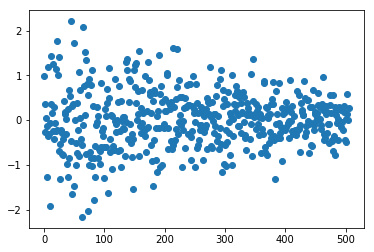

In [54]:
alpha = 0.998
heteps = hetero_eps(alpha,eps) # гетероскедастичный шум
plt.scatter(np.arange(N),heteps)

In [55]:
# добавьте к исходным значениям целевой переменой и Обучите модель и найдите R^2
# Подготовить данные CRIM и RM
X = df[['CRIM', 'RM']].values
y = data['target'] + heteps

# Обучите линейную регрессию стоимости дома на параметры CRIM и RM
model = LinearRegression(n_jobs=-1)
model.fit(X, y)

LinearRegression(n_jobs=-1)

In [56]:
y_pred = model.predict(X)
r2_score(y,y_pred)

0.5402594935861385

In [62]:
x = [1, 2, 3, 4, 5, 6]

In [64]:
for i in range(5):
    print((0.7*x[i+1] + 0.3*x[i]))

1.7
2.6999999999999997
3.6999999999999997
4.7
5.699999999999999


In [75]:
x = np.array([1, 0, 1, -1, 2, 0, 1])
alpha = np.array([0.2, 0.3, 0.5])

In [78]:
n = len(x) - len(alpha) + 1
for i in range(n):
    print(x[i:i+3]@alpha)

0.7
-0.2
0.9
0.39999999999999997
0.9
